# LINMA2472 - Group15's project : analysis of our musical tastes and further predictions

# Part 1 : analysis with audio features

Created on Dec 2020 \\
@authors : Juliette Glorieux, Tom Kenda & Colin Scherpereel \\
LINMA2472 - Algorithms in data science \\
Academic year : 2020 - 2021 \\

# Extraction of the database

For this part, we followed the example given in the following link : https://medium.com/deep-learning-turkey/build-your-own-spotify-playlist-of-best-playlist-recommendations-fc9ebe92826a

The codes were available here : https://github.com/smyrbdr/make-your-own-Spotify-playlist-of-playlist-recommendations/blob/master/Make_Your_Own_Playlist_of_Recs-with_PCA%2Btf-idf%2BDT_on_Blues.ipynb

In [1]:
!pip install spotipy

In [ ]:
#import spotipy
#from spotipy.oauth2 import SpotifyClientCredentials
#import spotipy.util as util
import numpy as np
import pandas as pd

Getting Spotify's authorizations

In [ ]:
secret = '7155faef93bd42648809c796ec82dcf2' # Client Secret; copy this from your app
username = 'Colin Scherpereel' # Your Spotify username
cid = '3f097271dcb64549b226e9b335e68fc3' # Client ID; copy this from your app 

#for available scopes see https://developer.spotify.com/web-api/using-scopes/
scope = 'user-library-read playlist-modify-public playlist-read-private'
redirect_uri = 'https://developer.spotify.com/dashboard/applications/3f097271dcb64549b226e9b335e68fc3'
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret) 
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
token = util.prompt_for_user_token(username, scope, cid, secret, redirect_uri)
if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)

# An URL will be asked. In order to get it, this code must be run with another
# python environment (we did it with Spyder4)

Loading the source playlists as dataframes

In [ ]:
# Creating dataframes of our playlists including tracks' names and audio features

# Playlist IDs
# Colin : '2vjaxQ0ZrMcdOs8YaaHs5M'
# Juliette : '0BGXzdAIvOJxSMALy48OHt'
# Tom : '4toOwkPzX5iAXMvixKRZf1'

playID = ['2vjaxQ0ZrMcdOs8YaaHs5M','0BGXzdAIvOJxSMALy48OHt','4toOwkPzX5iAXMvixKRZf1']
participants = ['Colin','Juliette','Tom']

for step in range(3):
  sourcePlaylistID = playID[step]
  sourcePlaylist = sp.user_playlist(username, sourcePlaylistID);
  tracks = sourcePlaylist["tracks"];
  songs = tracks["items"];

  track_ids = []
  track_names = []

  for i in range(0, len(songs)):
    if songs[i]['track']['id'] != None: # Removing the local tracks in our playlist if there is any
        track_ids.append(songs[i]['track']['id'])
        track_names.append(songs[i]['track']['name'])

  features = []
  for i in range(0,len(track_ids)):
    audio_features = sp.audio_features(track_ids[i])
    for track in audio_features:
        features.append(track)
        
  playlist_df = pd.DataFrame(features, index = track_names)
  playlist_df = playlist_df.iloc[0:100,[0,1,2,3,4,5,6,7,8,9,10,16,17]]
  playlist_df.to_csv('playlist{0}.csv'.format(participants[step]), index = False)

# Analysis with audio features

Importation of the database which consists of 13 audio features for 300 songs (100 songs for each participant in the project)

In [2]:
import numpy as np
import pandas as pd

In [3]:
# Reading the separate datasets and concatenating them
df_colin = pd.read_csv('playlistColin.csv')
df_juliette = pd.read_csv('playlistJuliette.csv')
df_tom = pd.read_csv('playlistTom.csv')

df_songs = pd.concat([df_colin,df_juliette,df_tom])
df_songs.shape

(300, 13)

In [4]:
# Reseting the indexes
df_songs = df_songs.reset_index()
del df_songs['index']

In [5]:
# Overview
df_songs.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.786,0.777,0,-5.666,1,0.1140,0.3470,0.000000,0.101,0.780,159.934,179120,4
1,0.649,0.700,9,-8.173,0,0.1930,0.1910,0.063300,0.339,0.727,159.846,167507,5
2,0.690,0.628,7,-12.813,1,0.0480,0.4980,0.069500,0.108,0.445,117.003,223925,4
3,0.643,0.619,9,-9.514,0,0.0357,0.0128,0.415000,0.351,0.140,128.785,305333,4
4,0.740,0.622,11,-4.608,0,0.0446,0.0357,0.000048,0.356,0.556,104.966,222707,4


The first 100 songs belong to Colin, the next 100 to Juliette and the last 100 to Tom (though a few songs may have been chosen by 2 or 3 of the participants). Now we have to remove the songs that belong to 2 or more people.

In [6]:
# Defining a function to compare two rows from a dataframe
def row_comparison(row1,row2):
  """
  Input : 2 rows from the same dataframe
  Output : boolean
    True if the rows are identical
    False otherwise
  """
  if len(row1) != len(row2):
    print("Rows don't have the same length")
    return False
  for col in range(len(row1)):
    if row1[col] != row2[col]:
      return False
  return True

In [7]:
# Removing the duplicates
# We must know how many songs were retrieved for every participant's set for further steps
indexes_to_delete = []

for i in range(len(df_songs)):
  for j in range(len(df_songs)):
    if i != j and row_comparison(df_songs.loc[i],df_songs.loc[j]):
      indexes_to_delete.append(j)
indexes_to_delete

[110, 137, 182, 10, 52, 66]

The indexes of the songs to delete are : 110, 137, 182, 10, 52 and 66. This means that Colin and Juliette will both lose 3 songs while Tom still has 100 songs in the dataset.

In [8]:
# Deleting the duplicate rows
for index in indexes_to_delete:
  df_songs = df_songs.drop(index)

In [9]:
# Reseting the indexes
df_songs = df_songs.reset_index()
del df_songs['index']
df_songs.shape

(294, 13)

## Visualization of the songs



Comparing t-SNE and PCA

In [10]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [11]:
# PCA for dimension reduction in 2D
play_pca = PCA(n_components = 2).fit_transform(df_songs)
x_pca = []
y_pca = []
for i in range(play_pca.shape[0]):
  x_pca.append(play_pca[i][0])
  y_pca.append(play_pca[i][1])

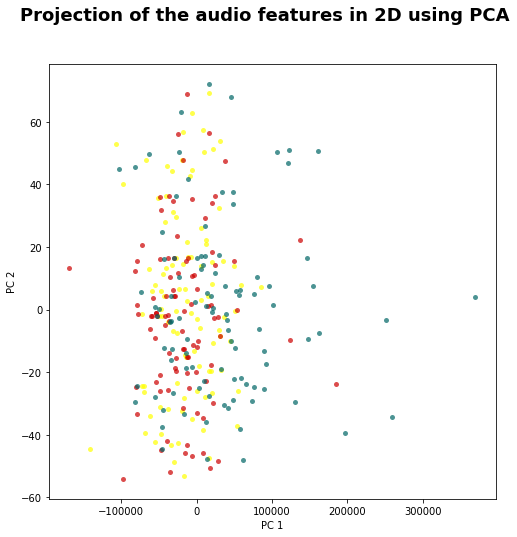

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [12]:
# Plotting in 2D using PCA, highlighting the 3 initial sets and the songs in common
fig = plt.figure(figsize = (8,8))
fig.suptitle("Projection of the audio features in 2D using PCA", fontsize = 18, fontweight = "bold")
# Scattering the songs belonging to the participants in different colors
plt.scatter(x_pca[:98], y_pca[:98], marker='.', s=100, lw=0, alpha=0.7, color= '#FFFF00')
plt.scatter(x_pca[98:195], y_pca[98:195], marker='.', s=100, lw=0, alpha=0.7, color= '#CC0000')
plt.scatter(x_pca[195:295], y_pca[195:295], marker='.', s=100, lw=0, alpha=0.7, color= '#006666')
plt.xlabel("PC 1")
plt.ylabel("PC 2")

plt.show()
#fig.savefig('PCA_projection.eps', format = 'eps')

In [13]:
# t-SNE for dimension reduction in 2D
play_tsne = TSNE(n_components=2).fit_transform(df_songs)
x_tsne = []
y_tsne = []
for i in range(play_tsne.shape[0]):
  x_tsne.append(play_tsne[i][0])
  y_tsne.append(play_tsne[i][1])

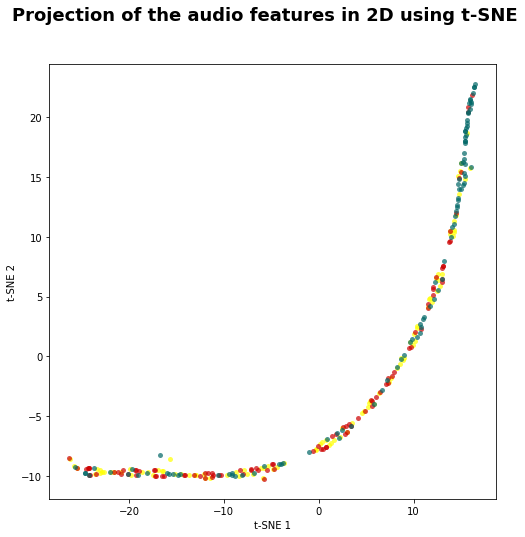

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [14]:
# Plotting in 2D using t-SNE, highlighting the 3 initial sets and the songs in common
fig = plt.figure(figsize = (8,8))
fig.suptitle("Projection of the audio features in 2D using t-SNE", fontsize = 18, fontweight = "bold")
# Scattering the songs belonging to the participants in different colors
plt.scatter(x_tsne[:98], y_tsne[:98], marker='.', s=100, lw=0, alpha=0.7, color= '#FFFF00')
plt.scatter(x_tsne[98:195], y_tsne[98:195], marker='.', s=100, lw=0, alpha=0.7, color= '#CC0000')
plt.scatter(x_tsne[195:], y_tsne[195:], marker='.', s=100, lw=0, alpha=0.7, color= '#006666')
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")

plt.show()
#fig.savefig('tSNE_projection.eps', format = 'eps')

We can see that t-SNE captures a lot more structure among the data than PCA does even though it seems difficult to analyse these projections. Indeed, reducing 13 audio features in 2 dimensions does not allow us to classify the songs properly.

We know that PCA tries to preserve the variability and the global structure among the data whereas t-SNE better preserves the local structures between the points. What we're interested in here is to keep the local structures in order to have an idea of "limits" that could exist between the songs of the 3 participants. We will thus go on with t-SNE for the rest of the homework.

## Analysis of the participants' musical tastes

### K-means clustering

The idea now will be to try to use the audio features to characterize the preferences of each participant and to try to define thresholds between those preferences for further predictions.

The first approach will be to try to cluster the songs into 3 groups with k-means clustering and see to what extent this algorithm is able to reidentify the participants' songs. We use k-means clustering with cosine distance applied to the initial number of dimensions. The centroids are chosen at random and the algorithm is run several times.

In [15]:
import numpy as np
array_songs = np.array(df_songs)

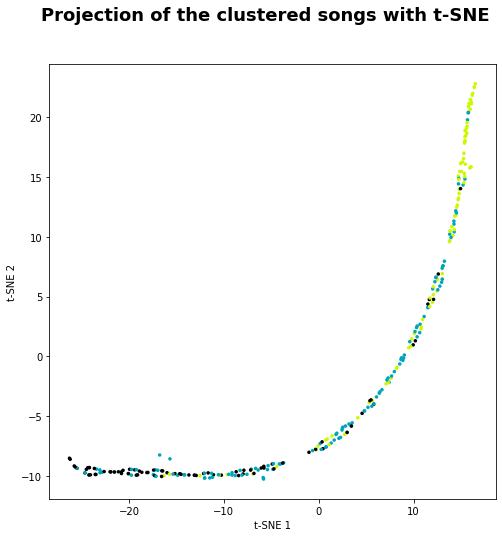

In [18]:
from nltk.cluster import KMeansClusterer
import nltk.cluster
import matplotlib.cm as cm

NUM_CLUSTERS = 3

# Performing the clustering on the 13D data with cosine distance
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance = nltk.cluster.util.cosine_distance, repeats = 100)
assigned_clusters = kclusterer.cluster(array_songs, assign_clusters = True)

# Defining different colors for the clusters
colors = cm.nipy_spectral(np.array(assigned_clusters).astype(float) / NUM_CLUSTERS)

# Plotting the results with t-SNE
fig = plt.figure(figsize = (8,8))
fig.suptitle("Projection of the clustered songs with t-SNE", fontsize = 18, fontweight = "bold")
plt.scatter(x_tsne, y_tsne, marker='.', s=50, lw=0, color = colors)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()
#fig.savefig('clusters_t-SNE.eps', format = 'eps')

The projection seems quite interesting as we can observe an evolution from one edge of the figure to the other. Unfortunately, the correspondance to reality doesn't seem quite good compared to the first projection we made. Let's compute a quality index to quantify the accuracy of the partition using jacard similarity.

In [17]:
import itertools 

def jaccard(index1,index2):
  """
  Computes the Jaccard similarity between two sets of clustering labels and indexes with different sizes.
  The value returned is between 0 and 1, inclusively. A value of 1 indicates
  perfect agreement between two clustering algorithms, whereas a value of 0
  indicates no agreement.
  """
  n = len(index1)
  n11 = n10 = n01 = 0
  for i, j in itertools.combinations(range(n), 2):
    comembership1 = (index1[i] == index1[j])
    comembership2 = (index2[i] == index2[j])
    if comembership1 and comembership2:
      n11 += 1
    elif comembership1 and not comembership2:
      n10 += 1
    elif not comembership1 and comembership2:
      n01 += 1
# To avoid ZeroDivisionError
  if n11 == 0:
    if n10 == 0 and n01 == 0:
      return 0

  return (float(n11) / (n11 + n10 + n01))

In [19]:
# Computing the jaccard similarity index
real_clusters = [0]*97 + [1]*97 + [2]*100
quality = round(jaccard(real_clusters,assigned_clusters),2)
print("The quality of partitioning reaches {0} %".format(quality*100))

The quality of partitioning reaches 21.0 %


With cosine distance and 100 iterations for the k-means algorithm, we obtain a jaccard similarity of ~ 22%. This is definitely not enough...
Let's try with euclidean distance : ~ 25%. This is better, however, we know that the 3 classes have the same number of elements and the classification here is far from respecting this rule.

Let's try with another clustering algorithm : the linear discriminant analysis

### Linear discriminant analysis

Linear discriminant analysis is a method of classification with supervised learning. The advantage here is that we will be able to tell the algorithm what kind of data we have before asking it to perform the clustering. We just have to split the data into a training set and a test set. For this purpose, we choose to use 80% of the songs as trainig set (chosen randomly) and 20% as test set.

Once it is done, we'll see to what extent the algorithm is able to reidentify the songs from the test set and from the entire set afterwards.

In [20]:
# Splitting the data into a training set and a test set
# And keeping the indexes for later
import copy
import random as rd

training_set = []
training_clusters = []
test_set = []
test_verif_clust = []

# Choosing songs randomly 
df_copy = copy.copy(df_songs)
clusters = copy.copy(real_clusters)
while len(training_set) < round(0.8*df_songs.shape[0]):
  choice = rd.choice(list(np.arange(df_copy.shape[0])))
  if list(df_copy.loc[choice]) not in training_set:
    training_set.append(list(df_copy.loc[choice]))
    training_clusters.append(clusters[choice])

# Defining the test set
for i in range(df_songs.shape[0]):
  if list(df_songs.loc[i]) not in training_set:
    test_set.append(list(df_songs.loc[i]))
    test_verif_clust.append(real_clusters[i])

In [21]:
## Importing the packages
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 

In [22]:
# Creating dataframes from our training and test sets
training_df = pd.DataFrame(training_set)
train_clust_df = pd.DataFrame(training_clusters)
train_clust_df.columns =['cluster'] 
training_df = pd.concat([training_df, train_clust_df], axis=1)
test_df = pd.DataFrame(test_set)

# Defining predictor and response variables
Pred = training_df[[0,1,2,3,4,5,6,7,8,9,10,11,12]]
Resp = training_df['cluster']

# Fitting the LDA model
model = LinearDiscriminantAnalysis()
model.fit(Pred, Resp)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [23]:
# Predictions for the test set
test_predict = list(model.predict(test_set))

# Comparing it to the real clusters
quality_pred = 0
for i in range(len(test_predict)):
  if test_predict[i] == test_verif_clust[i]:
    quality_pred += 1/len(test_predict)

print("The quality of prediction reaches {0} %".format(round(quality_pred*100),3))

The quality of prediction reaches 53 %


The quality of prediction reaches between 45% and 55%. This result isn't that bad considering the complexity to predict the owner of a song when the owners have rather similar preferences (the points were well mixed up in the graphs above).

Maybe a visualization of the predicted results could help us to understand what went wrong.

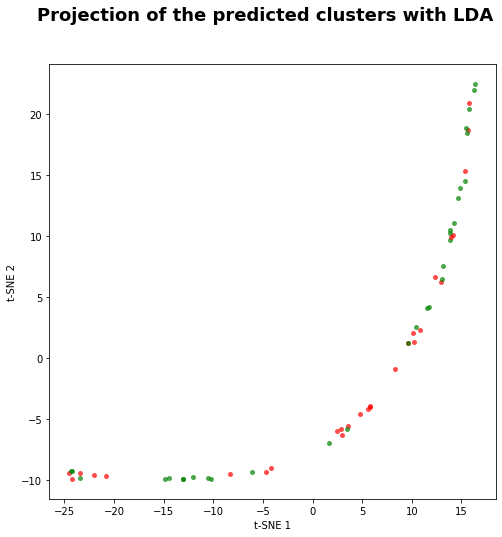

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

In [24]:
# Finding the indexes of the elements from the test_set
test_indexes = []
for i in range(len(test_set)):
  for j in range(df_songs.shape[0]):
    if test_set[i] == list(df_songs.loc[j]):
      test_indexes.append(j)

# Plotting in 2D using t-SNE
fig = plt.figure(figsize = (8,8))
fig.suptitle("Projection of the predicted clusters with LDA", fontsize = 18, fontweight = "bold")
# Scattering the songs belonging to the participants in different colors
for i in range(len(test_indexes)):
  if test_predict[i] == test_verif_clust[i]:
    plt.scatter(x_tsne[test_indexes[i]], y_tsne[test_indexes[i]], marker='.', s=100, lw=0, alpha=0.7, color= 'green')
  else:
    plt.scatter(x_tsne[test_indexes[i]], y_tsne[test_indexes[i]], marker='.', s=100, lw=0, alpha=0.7, color= 'red')
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")

plt.show()
#fig.savefig('test_set.eps', format = 'eps')

Unfortunaltely, there seems to be no logical distribution of the well predicted cases. 

However we can still try to see whether the model has a good level of accuracy on the whole set.

In [25]:
# Defining the whole set
whole_set = []
for i in range(df_songs.shape[0]):
  whole_set.append(list(df_songs.loc[i]))

# Predictions for the whole set
test_predict_whole = list(model.predict(whole_set))

# Comparing it to the real clusters
quality_whole = 0
for i in range(len(whole_set)):
  if test_predict_whole[i] == real_clusters[i]:
    quality_whole += 1/len(test_predict_whole)

print("The quality of prediction reaches {0} %".format(round(quality_whole*100),3))

The quality of prediction reaches 56 %


The quality of prediction reaches between 50% and 60%. It seems like we won't be able to go further and do better. Once again, maybe we can have a look at the distribution of the well classified songs.

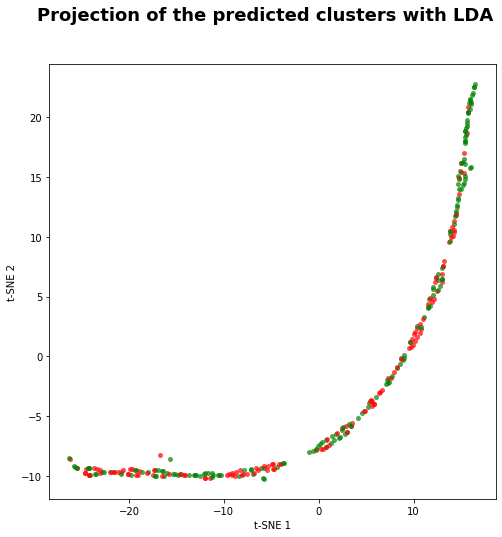

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

In [26]:
# Plotting in 2D using t-SNE
fig = plt.figure(figsize = (8,8))
fig.suptitle("Projection of the predicted clusters with LDA", fontsize = 18, fontweight = "bold")
# Scattering the songs belonging to the participants in different colors
for i in range(len(whole_set)):
  if test_predict_whole[i] == real_clusters[i]:
    plt.scatter(x_tsne[i], y_tsne[i], marker='.', s=100, lw=0, alpha=0.7, color= 'green')
  else:
    plt.scatter(x_tsne[i], y_tsne[i], marker='.', s=100, lw=0, alpha=0.7, color= 'red')
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")

plt.show()
#fig.savefig('whole_set.eps', format = 'eps')

As we can see, the model seems to rather easily classify correctly the points from the lower part of the graph but still has a lot of difficulty to do so for the rest of the songs.

## Predictions of best appreciations

For predictions, we selected 22 songs that were known by us three and for which we couldn't decide who liked them the most. We now want that the model decides for us.

In [ ]:
# Reading the csv file with songs for predictions
df_to_predict = pd.read_csv('playlistpred.csv')

# Defining a list with the songs for which the model will predict the most probable owner
songs_to_pred = []
for i in range(df_to_predict.shape[0]):
  songs_to_pred.append(list(df_to_predict.loc[i]))

In [ ]:
# Making predictions
predictions = list(model.predict(songs_to_pred))
prop_owner = []
for i in range(len(predictions)):
  if predictions[i] == 0:
    prop_owner.append("Colin")
  elif predictions[i] == 1:
    prop_owner.append("Juliette")
  else:
    prop_owner.append("Tom")

In [ ]:
# These are the names of the extracted songs used for predictions
names = ["La gloire ou l'asile","Là-haut","Fais fumer le pangolin","Ginkgo Biloba",
 "Dying in LA","Sundance","Chalouper","Rêver","Nothing Comes Close","Pesetas",
 "Before You Go","Queen (feat. Quinn XCII)","Fairly Local","Don't Forget Where You Belong",
 "Pauvre monde","Perdu D'avance","C'est pas bien","Ulysses and the Sea","Désolé pour hier soir",
 "Tu Es","Uprising","Fever"]

 # And these are the predictions
dico_pred = {}
for song in range(len(names)):
  dico_pred[names[song]] = prop_owner[song]

print(dico_pred)

{"La gloire ou l'asile": 'Colin', 'Là-haut': 'Tom', 'Fais fumer le pangolin': 'Juliette', 'Ginkgo Biloba': 'Tom', 'Dying in LA': 'Juliette', 'Sundance': 'Juliette', 'Chalouper': 'Colin', 'Rêver': 'Juliette', 'Nothing Comes Close': 'Juliette', 'Pesetas': 'Juliette', 'Before You Go': 'Juliette', 'Queen (feat. Quinn XCII)': 'Juliette', 'Fairly Local': 'Colin', "Don't Forget Where You Belong": 'Tom', 'Pauvre monde': 'Tom', "Perdu D'avance": 'Tom', "C'est pas bien": 'Colin', 'Ulysses and the Sea': 'Juliette', 'Désolé pour hier soir': 'Colin', 'Tu Es': 'Colin', 'Uprising': 'Tom', 'Fever': 'Juliette'}


Validation for such a classification isn't easy : this will be discussed in the report.